/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Out-of-range loss (MSE): 546.74568
Training loss: 0.8078697323799133
Validation loss: 1.0595372915267944


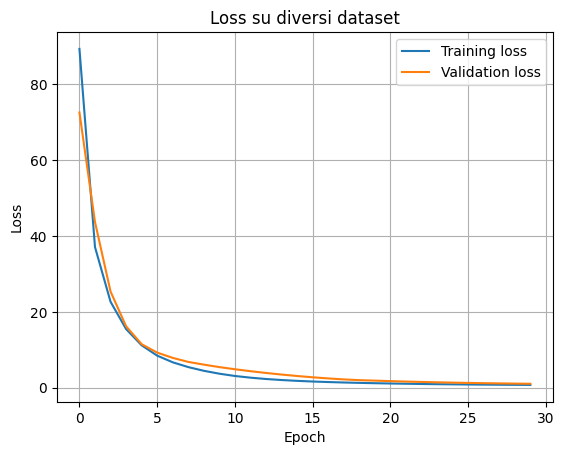

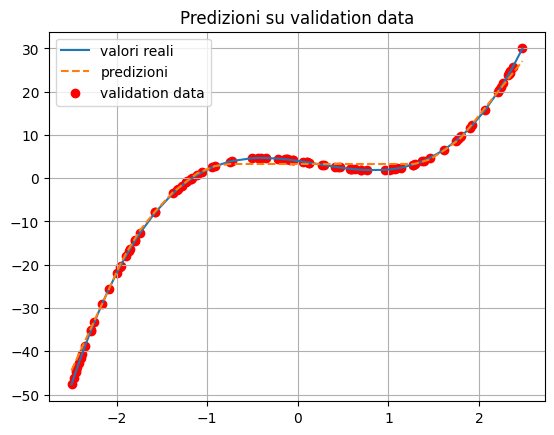

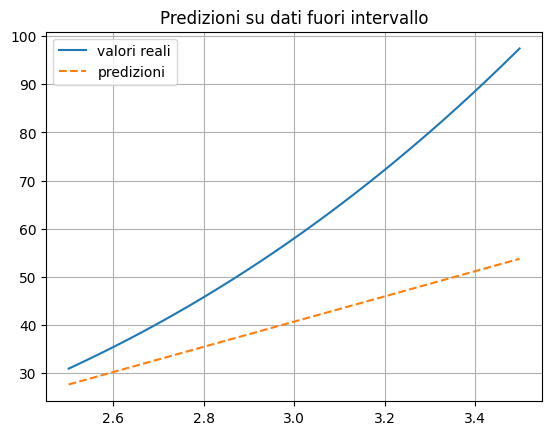

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

# parametri della funzione target f(x) = ax^3 + bx^2 + cx + d
a = 3
b = -2
c = -3
d = 4
epoche = 30

# imposto i seed per replicabilità dei dati
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#genero i dati di validazione e di allenamento
x_train = np.random.uniform(-2.5, 2.5, 1000)
x_valid = np.random.uniform(-2.5, 2.5, 100)
x_valid.sort()
y_target = a * (x_valid**3) + b * (x_valid**2) + c * x_valid + d # funzione target ideale
#generazione di dati fuori dall'intervallo di validazione ed allenamento
x_out = np.random.uniform(2.5, 3.5, 100)
x_out.sort()
y_out_target = a * (x_out**3) + b * (x_out**2) + c * x_out + d #funzione target fuori intervallo

sigma = 0.0 # rumore nei dati
#ordinate dei dati di validazione, addestramento e di quelli fuori intervallo
y_train = np.random.normal(a * (x_train**3) + b * (x_train**2) + c * x_train + d, sigma)
y_valid = np.random.normal(a * (x_valid**3) + b * (x_valid**2) + c * x_valid + d, sigma)
y_out = np.random.normal(a * (x_out**3) + b * (x_out**2) + c * x_out + d,sigma)

#inizializzo la rete neurale
model = tf.keras.Sequential()
model.add(Dense(60, input_shape=(1,), activation='relu'))
model.add(Dense(1, activation='linear')) #uso linear nell'output layer perchè la funzione polinomiale può assumere valori di ogni tipo


#ciclo di addestramento
model.compile(optimizer='sgd', loss='mse')
history = model.fit(x=x_train, y=y_train,
          batch_size=32, epochs=epoche,
          shuffle=True, # mischio i dati ad ogni epoca
          validation_data=(x_valid, y_valid),
          verbose=0)

#calcolo la loss (quindi MSE) su x_out
y_pred = model.predict(x_out, verbose=0)
mse_out = tf.reduce_mean(tf.square(y_pred.flatten() - y_out)).numpy()
print(f"Out-of-range loss (MSE): {mse_out:.5f}")

#calcolo e stampo la loss sui dati di addestramento e validazione
loss_train = model.evaluate(x_train, y_train, verbose=0)
loss_valid = model.evaluate(x_valid, y_valid, verbose=0)
print(f"Training loss: {loss_train}")
print(f"Validation loss: {loss_valid}")

#plotto la loss sui dati di validazione e addestramento
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss su diversi dataset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.close()

# Plotto funzione target, validation data e predizione della rete neurale
y_pred_valid = model.predict(x_valid, verbose=0)
plt.plot(x_valid, y_target, label='valori reali')
plt.plot(x_valid, y_pred_valid, label='predizioni', linestyle='--')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.title("Predizioni su validation data")
plt.show()

plt.close()

#plotto predizione della rete neurale su x_out e funzione target su x_out
plt.plot(x_out, y_out_target, label='valori reali')
plt.plot(x_out, y_pred, label='predizioni', linestyle='--')
plt.legend()
plt.grid(True)
plt.title("Predizioni su dati fuori intervallo")
plt.show()

plt.close()

# Esercizio 11.2

La rete neurale è stata costruita basandosi sul teorema di Lu sull'universal approximation per reti con larghezza limitata. Tale teorema stabilisce che per approssimare qualsiasi funzione Lebesgue integrabile in $n$ dimensioni dimensioni è necessaria una rete neurale con layer di minimo $n +1$ neuroni con funzione di attivazione $ReLu$.

In questo caso di funzione polinomiale 1D ho utilizzato un layer di $60$ neuroni. In generale si osserva una diminuzione significativa della loss e una migliore predizione sui dati fuori intervallo che sui dati di addestramento e validazione al crescere di neuroni nello strato nascosto.

Per funzioni non lineari è necessaria una funzione di attivazione non lineare, come $ReLu$. Il neurone di output invece ha funzione di attivazione lineare perchè la funzione polinomiale può assumere qualsiasi valore reale. Si nota come aumentando la complessità della rete neurale aggiungendo hidden layer la prestazione peggiora invece di migliorare, soprattutto con l'utilizzo di optimizer non opportunamente controllati che portano a una over-parametrizzazione e più difficoltà nell'addestramento.

Per diminuire la loss e rendere più efficaci le previsioni sui dati si può agire sulla dimensione dell'hidden layer o aumentando il numero di epoche.

Come optimizers ho scelto $sgd$, adatto anche per funzioni polinomiali. Come loss ho scelto $mse$, efficacie per problemi di regressione come questo.

La rete neurale apprende bene la funzione polinomiale nel range di training mostrando una buona accuratezza nelle predizioni su dati nuovi all'interno dell'intervallo. Tuttavia, le prestazioni calano significativamente fuori dal range, a causa della natura intrinseca delle reti neurali che sono progettate principalmente per interpolare e non per estrapolare. Il comportamento al di fuori dell'intervallo non rientra in ciò che ha imparato la rete e potrebbe deviare molto rispetto all'approssimazione della funzione target interpolata dalla rete dentro l'intervallo di addestramento. Inoltre, la complessità del modello influenza questo comportamento: un modello troppo semplice non cattura bene la funzione, mentre uno troppo complesso può overfittare, peggiorando la capacità di generalizzazione, in particolare fuori dal range di addestramento.